# Rescheduling mit Tardiness (Max)
> Planunghorizont Tag 0: 2 Tage <br>
> Rescheduling des Tages 1

In [1]:
import time

In [2]:
import pandas as pd
import pulp

pd.set_option('display.max_rows', 20)

In [3]:
import utils.presenter as show
import utils.checker as check

import utils.schedule_interarrival as sit
import utils.scheduling_solver as ssv
import utils.rescheduling_solver_tardiness as rssv

from ProductionDaySimulation import ProductionDaySimulation

In [4]:
import utils.rolling_planning.init_jobs_times as rp_init
import utils.schedule_deadline as deadline_gen

In [5]:
max_time = 60*60*6 # 6h

main_file_path = "../main_data/{}"

In [6]:
df_instance = pd.read_csv("data/00_instance.csv")
df_instance

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


In [7]:
df_jssp, df_arrivals = rp_init.init_jobs_with_arrivals(df_instance, 2,  u_b_mmax = 0.9)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
375,Job_037,5,M9,76
376,Job_037,6,M5,47
377,Job_037,7,M3,52
378,Job_037,8,M4,90


In [8]:
df_times = deadline_gen.get_times_df(df_jssp, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1.0, buffer_factor=1.2)
df_times

,Job,Arrival,Deadline
0,Job_000,0.00,1246.64412
1,Job_001,88.05,1697.641143
2,Job_002,152.78,1945.422685
3,Job_003,207.97,2275.189997
4,Job_004,246.61,1486.941998
...,...,...,...
33,Job_033,2630.89,4698.109997
34,Job_034,2637.28,3877.611998
35,Job_035,2638.72,4431.362685
36,Job_036,2764.04,4010.68412


## I) Complete Scheduling

In [9]:
starting_time = time.time()

# Scheduling
df_plan = ssv.solve_jssp_max_tardiness(df_jssp, df_times, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.05)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan

BigM: 11000

Solver-Informationen:
  Maximale Tardiness      : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 7487
  Anzahl Constraints      : 14516

Scheduling-Dauer: 21 Minuten und 31.83 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_000,0,0.00,1246.644120,M0,0.00,29.0,29.00,0
1,Job_000,1,0.00,1246.644120,M1,29.00,78.0,107.00,0
2,Job_000,2,0.00,1246.644120,M2,107.00,9.0,116.00,0
3,Job_000,3,0.00,1246.644120,M3,116.00,36.0,152.00,0
4,Job_000,4,0.00,1246.644120,M4,152.00,49.0,201.00,0
...,...,...,...,...,...,...,...,...,...
375,Job_033,7,2630.89,4698.109997,M3,4422.28,98.0,4520.28,0
376,Job_037,8,2869.61,4573.882975,M4,4422.28,90.0,4512.28,0
377,Job_037,9,2869.61,4573.882975,M7,4512.28,45.0,4557.28,0
378,Job_033,8,2630.89,4698.109997,M9,4520.28,22.0,4542.28,0


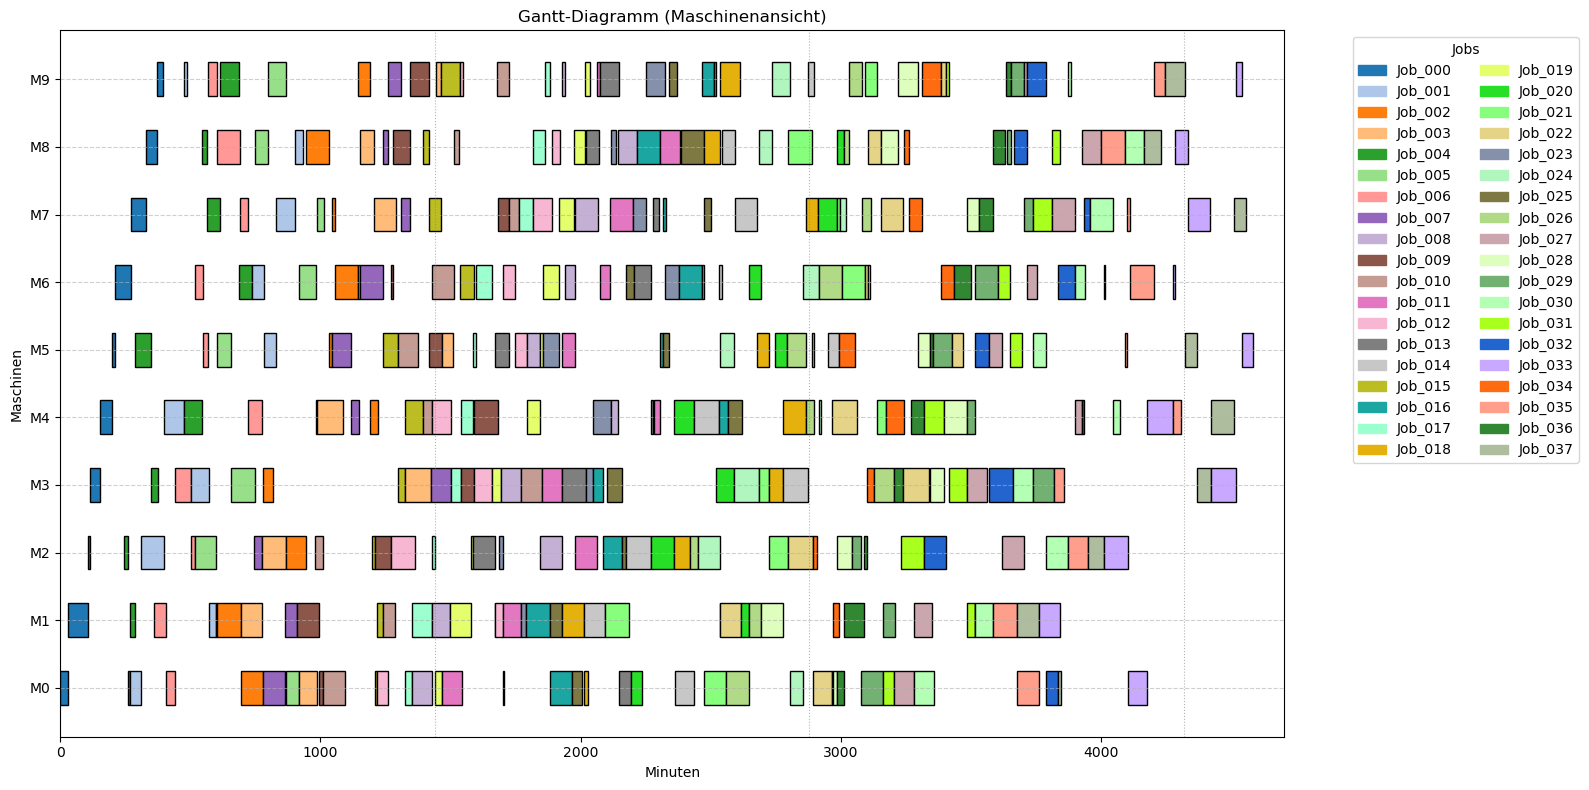

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [10]:
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

## II) Erster Tag (Tag 0)

### a) Simulation

In [11]:
day_length = 1440

In [12]:
day_numb = 0

day_start = day_length*day_numb 
day_end = day_start + day_length

In [13]:
simulation = ProductionDaySimulation(df_plan, vc=0.35)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:13:11] Job_000 finished on M0 (after 13 minutes 12 seconds)
[00:29:00] Job_000 started on M1
[02:05:27] Job_000 finished on M1 (after 96 minutes 28 seconds)
[02:05:27] Job_000 started on M2
[02:14:43] Job_000 finished on M2 (after 09 minutes 16 seconds)
[02:14:43] Job_000 started on M3
[02:45:09] Job_000 finished on M3 (after 30 minutes 26 seconds)
[02:45:09] Job_000 started on M4
[03:20:06] Job_000 finished on M4 (after 34 minutes 58 seconds)
[03:21:00] Job_000 started on M5
[03:36:07] Job_000 finished on M5 (after 15 minutes 07 seconds)
[03:36:07] Job_000 started on M6
[04:06:36] Job_004 started on M2
[04:25:46] Job_004 finished on M2 (after 19 minutes 10 seconds)
[04:25:46] Job_004 started on M0
[04:30:59] Job_004 finished on M0 (after 05 minutes 13 seconds)
[04:30:59] Job_001 started on M0
[04:30:59] Job_004 started on M1
[04:59:34] Job_004 finished on M1 (after 28 minutes 35 seconds)
[04:59:34] Job_004 started on M5
[05:06:19] Job_001 finished 

In [14]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_007,6,515.63,M8,1241.74,19.0
1,Job_007,7,515.63,M9,1260.74,48.0
2,Job_009,3,781.95,M6,1272.28,7.0
3,Job_009,4,781.95,M8,1279.28,64.0
4,Job_007,8,515.63,M7,1308.74,36.0
...,...,...,...,...,...,...
279,Job_033,7,2630.89,M3,4422.28,98.0
280,Job_037,8,2869.61,M4,4422.28,90.0
281,Job_037,9,2869.61,M7,4512.28,45.0
282,Job_033,8,2630.89,M9,4520.28,22.0


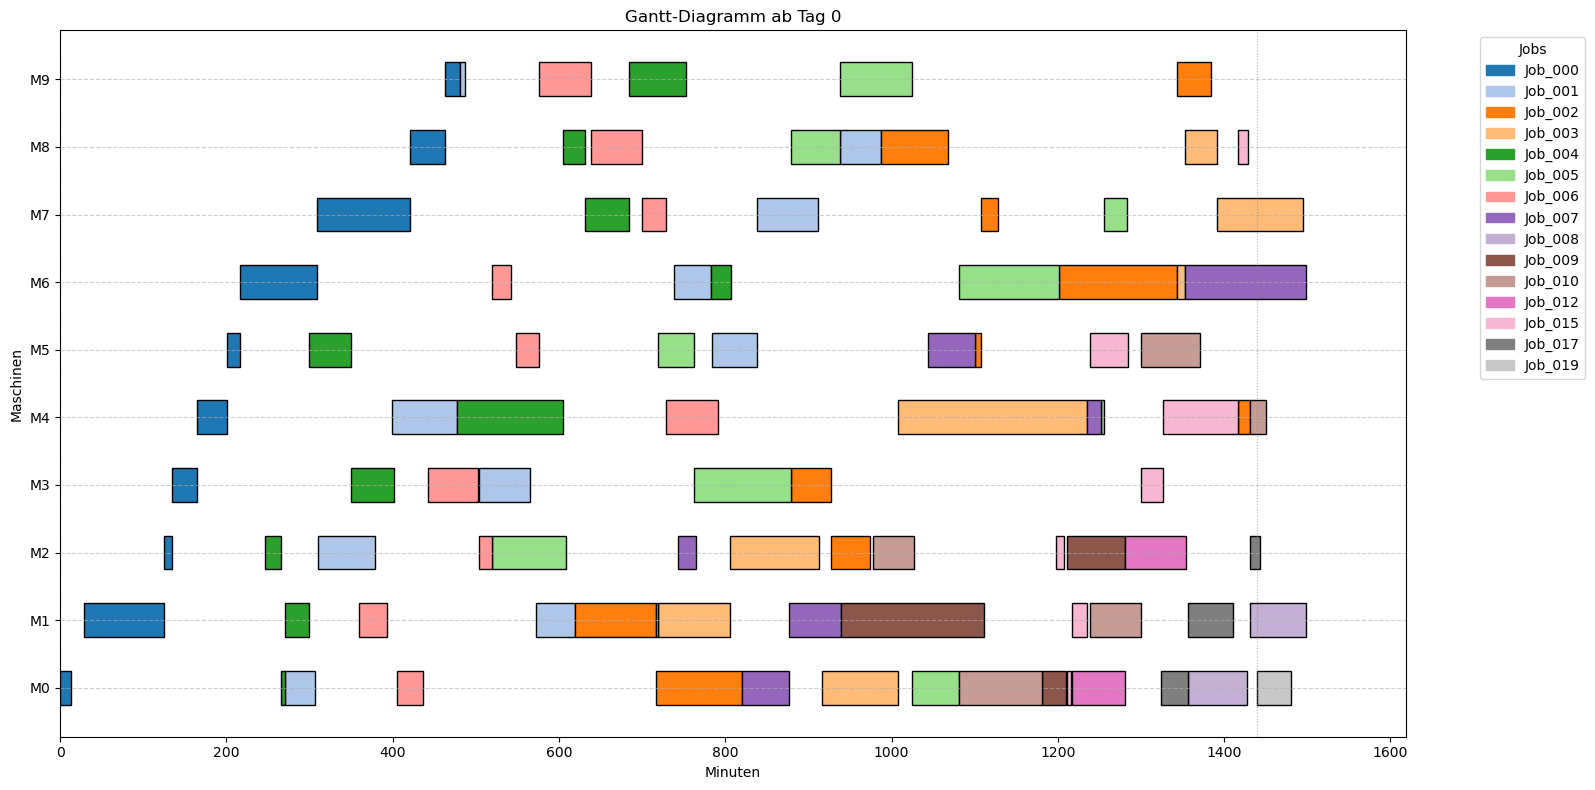

In [15]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm ab Tag {day_numb}", duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

### b) Verbleibene Jobs (Rest)

In [16]:
df_rest = df_plan.merge(df_execution[["Job", "Machine"]], on=["Job", "Machine"], how="left", indicator=True)
df_rest = df_rest[df_rest["_merge"] == "left_only"].drop(columns=["_merge"])
df_rest = df_rest.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_rest

,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_003,7,207.97,2275.189997,M3,1326.28,98.0,1424.28,0
1,Job_003,8,207.97,2275.189997,M9,1443.28,22.0,1465.28,0
2,Job_003,9,207.97,2275.189997,M5,1466.28,43.0,1509.28,0
3,Job_007,6,515.63,2216.746914,M8,1241.74,19.0,1260.74,0
4,Job_007,7,515.63,2216.746914,M9,1260.74,48.0,1308.74,0
...,...,...,...,...,...,...,...,...,...
279,Job_037,5,2869.61,4573.882975,M9,4247.28,76.0,4323.28,0
280,Job_037,6,2869.61,4573.882975,M5,4323.28,47.0,4370.28,0
281,Job_037,7,2869.61,4573.882975,M3,4370.28,52.0,4422.28,0
282,Job_037,8,2869.61,4573.882975,M4,4422.28,90.0,4512.28,0


In [17]:
allowed = df_rest["Job"].unique() 
df_time_rest = df_times[df_times["Job"].isin(allowed)].copy()
df_time_rest

,Job,Arrival,Deadline
3,Job_003,207.97,2275.189997
7,Job_007,515.63,2216.746914
8,Job_008,748.04,2632.208455
9,Job_009,781.95,2486.222975
10,Job_010,891.94,2593.056914
...,...,...,...
33,Job_033,2630.89,4698.109997
34,Job_034,2637.28,3877.611998
35,Job_035,2638.72,4431.362685
36,Job_036,2764.04,4010.68412


## III) Rescheduling
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [18]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
36,Job_003,6,207.97,M7,1391.59,103.50,1287.12,1495.09
72,Job_007,5,515.63,M6,1352.99,145.76,983.12,1498.75
74,Job_008,1,748.04,M1,1431.04,67.83,750.83,1498.87
82,Job_010,4,891.94,M4,1431.52,19.31,558.89,1450.83
94,Job_017,2,1324.04,M2,1431.04,12.00,119.00,1443.04
95,Job_019,0,1440.00,M0,1440.00,40.01,40.01,1480.01


In [19]:
starting_time = time.time()
df_reschedule = rssv.solve_jssp_max_tardiness_with_fixed_ops(df_rest, df_time_rest, df_execution_important,
                                                                   reschedule_start = 1440,
                                                                   solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.05)
# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")

df_reschedule


Solver-Informationen:
  Maximale Tardiness      : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 4444
  Anzahl Constraints      : 8570

Scheduling-Dauer: 4 Minuten und 51.70 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_017,3,1324.04,2570.684120,M3,1443.04,36.0,1479.04,0
1,Job_017,4,1324.04,2570.684120,M4,1479.04,49.0,1528.04,0
2,Job_011,0,944.71,2828.878455,M0,1480.01,76.0,1556.01,0
3,Job_013,0,1185.73,2751.136288,M2,1492.87,84.0,1576.87,0
4,Job_003,7,207.97,2275.189997,M3,1495.09,98.0,1593.09,0
...,...,...,...,...,...,...,...,...,...
279,Job_037,8,2869.61,4573.882975,M4,4438.88,90.0,4528.88,0
280,Job_033,7,2630.89,4698.109997,M3,4467.09,98.0,4565.09,0
281,Job_037,9,2869.61,4573.882975,M7,4528.88,45.0,4573.88,0
282,Job_033,8,2630.89,4698.109997,M9,4565.09,22.0,4587.09,0


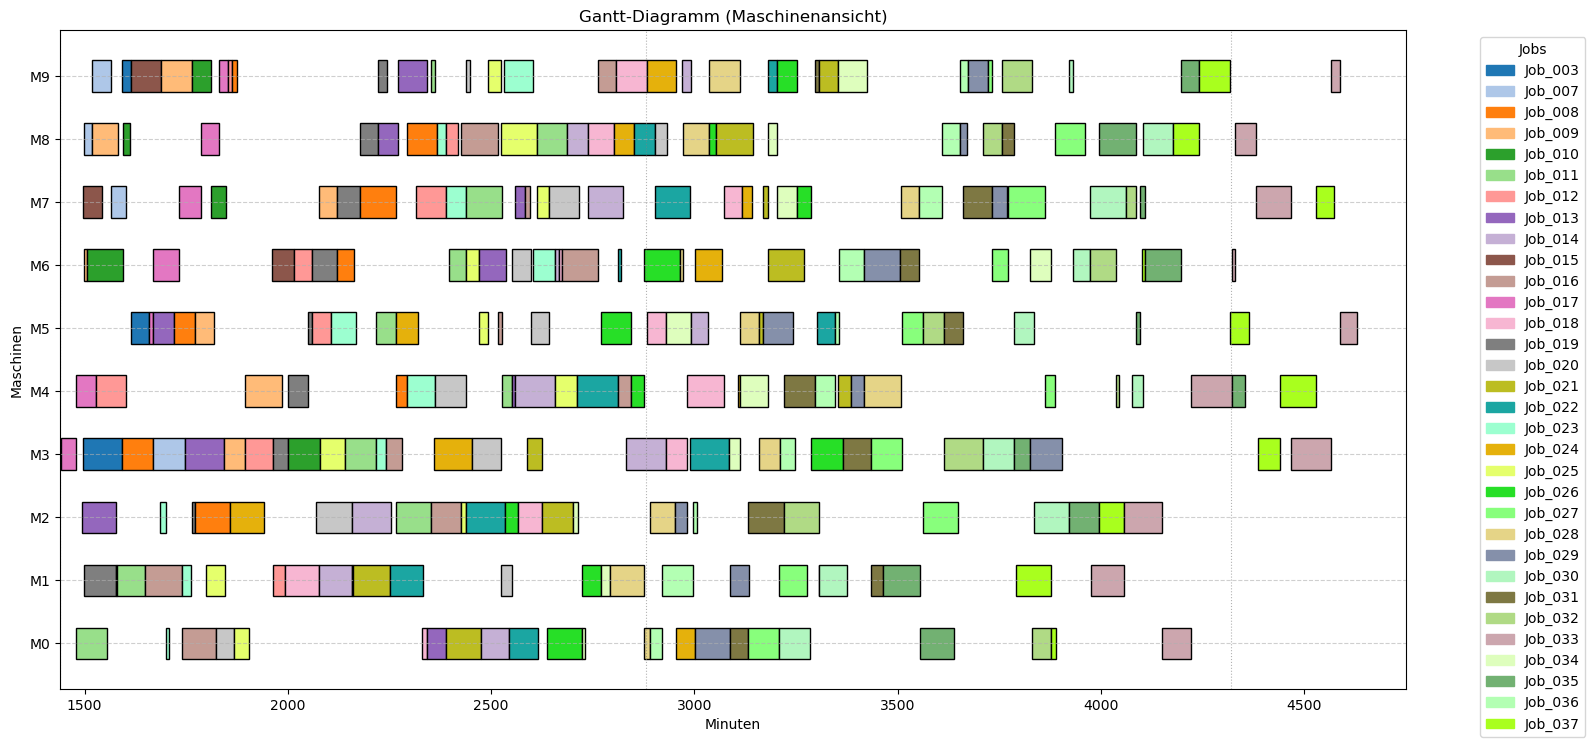

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [20]:
show.plot_gantt_machines(df_reschedule)
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)

### Export

In [21]:
df_plan.to_csv(main_file_path.format("0204b_tardiness_max_schedule_og.csv"), index = False)
df_execution.to_csv(main_file_path.format("0204b_tardiness_max_schedule_simulation.csv"), index = False)
df_reschedule.to_csv(main_file_path.format("0204b_tardiness_max_schedule_revised.csv"), index = False)

In [22]:
df_execution = df_execution.rename(columns={"Simulated Processing Time": "Processing Time"})

df_schedule_mix = pd.concat([df_execution, df_reschedule], ignore_index=True)
df_schedule_mix = df_schedule_mix.sort_values(by="Start").reset_index(drop=True)
df_schedule_mix.to_csv(main_file_path.format("0204b_tardiness_max_schedule_revised_with_sim.csv"), index = False)